#QUINCY HERSHEY - ALEX MOORE - ADAM DICHIARA - SCOTT TANG - VINCENT FILARDI
#CS541 Project: MAML CNN
---


In [1]:
!pip install learn2learn
!pip install torchmeta

import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import learn2learn as l2l
import torch.utils
from torchmeta.modules import (MetaModule, MetaSequential, MetaConv2d,
                               MetaBatchNorm2d, MetaLinear)
from torchmeta.utils.gradient_based import gradient_update_parameters

colab=True
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Project/data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## RESISC45

---

In [2]:
np.random.seed(1)
random.seed(1)
test_size = 0.8
val_size = 0.2
batch_size = 32
MAML_learning_rate = 0.0006
MAML_learning_rate = 0.0006
CNN_learning_rate = 0.0006
MAML2_learning_rate1=.00045
MAML2_learning_rate2=0.0001/8
n_epochs = 150
print_stride = 10
Freeze=False
First_Train = True
no_load = True
bce_loss = nn.BCELoss()
No_Overlap = False

In [3]:
class CustomTensorDataset(Dataset):

    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform=transform

    def __getitem__(self, index):
        X = self.images[index]
        y = self.labels[index]
        return X, y

    def __len__(self):
        return len(self.images)

def make_dataset(x, y):
    x = torch.tensor(x).permute(0,3,1,2)
    y = torch.tensor(y)
    dset = CustomTensorDataset(x, y)
    return dset

In [4]:
def get_data(dir, mtype,nwaykshot=False,No_Overlap=False):
    if mtype=='MAML': batch_n = batch_size*2
    else: batch_n = batch_size

    data = np.load(dir+'RESISC45_images_96.npy')
    labels = np.load(dir+'RESISC45_classes.npy')
    classes = np.load(dir+'RESISC45_class_names.npy')
    if No_Overlap:
        scenes = ['airport',
                  'basketball_court',
                  'bridge',
                  'church',
                  'circular_farmland',
                  'cloud',
                  'commercial_area',
                  'desert',
                  'ground_track_field',
                  'industrial_area',
                  'island',
                  'lake',
                  'meadow',
                  'mountain',
                  'palace',
                  'railway',
                  'railway_station',
                  'rectangular_farmland',
                  'roundabout',
                  'sea_ice',
                  'ship',
                  'snowberg',
                  'stadium',
                  'terrace',
                  'thermal_power_station',
                  'wetland']
        mask = np.isin(classes, scenes)
        classes = classes[mask]
        filterset = np.arange(len(mask))[mask]
        mask = np.isin(labels, filterset)
        labels = labels[mask]
        data = data[mask]
        setlabs = list(set(labels))
        labels = np.array([setlabs.index(x) for x in labels])
    #img_size = train_data.shape[2]
    c_dim = classes.shape[0]

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size, stratify = labels)

    xtrain, xval, ytrain, yval = train_test_split(train_data, train_labels, test_size = val_size)
    trainset = make_dataset(xtrain,ytrain)
    train_loader = DataLoader(trainset, batch_size=int(batch_n), shuffle=True)

    valset = make_dataset(xval, yval)
    val_loader = torch.utils.data.DataLoader(valset, batch_n, drop_last = True, shuffle=True)

    testset = make_dataset(test_data, test_labels)
    test_loader = torch.utils.data.DataLoader(testset, batch_n, drop_last = True, shuffle=True)
    if nwaykshot==True:
        return trainset, val_loader, test_loader, c_dim, classes, ytrain
    return train_loader, val_loader, test_loader, c_dim, classes
def tasksplit_uneven(x,y,Params):
    ## split inner and outer loop by incidies
    skip =2 
    idx = idx = torch.arange(start =1, end=x.shape[0]+1).bool()
    idx[::skip] = False
    x_inner = x[idx]
    y_inner = y[idx]
    x_outer = x[~idx]
    y_outer = y[~idx]
    return x_inner, x_outer, y_inner,y_outer

In [5]:

import learn2learn as l2l
def taskStructure(dataset,Params,trainlabels): ## pass train into here
    labels= {}
    for i in range(Params['num_classes']):
        labels[i] = [j for j, x in enumerate(trainlabels) if x == i]
    metaDataset = l2l.data.MetaDataset(dataset,labels_to_indices=labels)
    
    transforms = [
    ## need kshots*2 for inner and outer loop split accross each task
        l2l.data.transforms.FusedNWaysKShots(metaDataset,n=Params['nways'],k=Params['kshots']*2,replacement=False),
        l2l.data.transforms.LoadData(metaDataset),
        l2l.data.transforms.ConsecutiveLabels(metaDataset)
    ]
    taskset = l2l.data.TaskDataset(metaDataset,
                                   transforms,
                                   num_tasks=len(dataset)/(Params['nways']*Params['kshots']*2))
        
    return taskset


In [6]:
class Conv_Pred(nn.Module):
    def __init__(self):
        super(Conv_Pred, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1) # Input: (batch_size, 3, img_size, img_size)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
        self.conv4_bn = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 1024, 4, 2, 1, bias = False)
        self.conv6_bn = nn.BatchNorm2d(1024)
        
        self.fce = nn.Linear(1024, 45)


    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])

    def forward(self, x):
        x = x/127.5 - 1.0
        x = F.relu(self.conv1(x), 0.2)
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))

        z = nn.Softmax(dim=1)(self.fce(x.squeeze()))

        return z

    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


def get_model(mtype, lr=0.0006, train=True,load=False):
    model = Conv_Pred().to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model


def normal_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)

def one_hot_embedding(labels, dims):
    labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64), num_classes = dims)
    return torch.squeeze(labels)

def accuracy_topk(output, target, topk=(3,)):
    #https://forums.fast.ai/t/return-top-k-accuracy/27658
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res[0]

In [7]:
## for general MAML
class ConvolutionalNeuralNetwork(MetaModule):
    def __init__(self,Params,in_channels=3,out_features=45,hidden_size=2):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.in_channels = Params['in_channels']
        self.out_features = Params['num_classes']
        self.hidden_size = Params['hidden_size']

        self.features  = MetaSequential(
            MetaConv2d(in_channels,hidden_size**5,kernel_size=4,stride=2,padding=1),
            nn.ReLU(),
            MetaConv2d(hidden_size**5,hidden_size**6,kernel_size=4,stride=2,padding=1,bias=False),
            MetaBatchNorm2d(hidden_size**6),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 6, hidden_size ** 7, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size**7),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 7, hidden_size ** 8, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 8),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 8, hidden_size ** 9, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 9),
            nn.ReLU(),
            MetaConv2d(hidden_size ** 9, hidden_size ** 10, kernel_size=4, stride=2, padding=1, bias=False),
            MetaBatchNorm2d(hidden_size ** 10),
            nn.ReLU(),
        )
        self.fce = MetaLinear(self.hidden_size**10, out_features)



    def weight_init(self):
        for m in self._modules:
            normal_init(self._modules[m])
    def forward(self, inputs, params=None):
        features = self.features(inputs, params=self.get_subdict(params, 'features'))
        features = features.view((features.size(0), -1))
        logits = self.fce(features, params=self.get_subdict(params, 'classifier'))
        return logits
        
    def save(self, name):
        print('saving...')
        torch.save({
            'model_state_dict': self.state_dict() #,
            #'optimizer_state_dict': self.optimizer.state_dict(),
        }, dir+name+'.pt')

    def load(self, name):
        print('loading...')
        checkpoint = torch.load(dir+name+'.pt')
        self.load_state_dict(checkpoint['model_state_dict'])

def get_meta_model(Params,train=True,load=False):
    model = ConvolutionalNeuralNetwork(Params).to(device)
    model.weight_init()
    if load==True:
        try: model.load(mtype)
        except: pass
    if train == True:
        model.train()
    else:
        model.eval()
    return model

In [8]:
#augmentation_functions.py

class addGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, p=0.5):
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)
        self.p = p
      
    def __call__(self, img):
        if torch.rand(1).item() < self.p:
            return img + torch.randn(img.size(), device = device) * self.std + self.mean
        return img
        
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1}, p={2})'.format(self.mean, self.std, self.p)

def applyAugs(img_batch, task_idx, num_augs=7):
    # returns augmented batch of images based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(96,
                                                   scale=(0.5, 1.0),
                                                   ratio=(0.8, 1.0)),
                                                   #interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)
    img_batch = transform(img_batch)
    return img_batch

def getAugmentationTransforms(task_idx, num_augs=7):
    # returns transforms.Compose function of transforms based on task index (0:128)
    # currently based on exactly 7 transforms 

    transform_list = [transforms.RandomHorizontalFlip(p=0.99),
                      transforms.RandomVerticalFlip(p=0.99),
                      transforms.RandomRotation(359.0, fill=0.5),
                      transforms.RandomPerspective(distortion_scale=0.1, p=0.99, fill=0.5),
                      transforms.RandomResizedCrop(256,
                                                   scale=(0.5, 1.0),
                                                   ratio=(1.0, 1.0),
                                                   interpolation=transforms.InterpolationMode.BILINEAR),
                      addGaussianNoise(std=0.1, p=0.99),
                      # transforms.ColorJitter(saturation=4.0, hue=0.01),
                      transforms.ColorJitter(brightness=0.5, contrast=0.9)
                      # ,transforms.GaussianBlur(9, sigma=(0.01, 2.0))
                      ]
       
    tasklist = list(itertools.product([0, 1], repeat=num_augs))
    current_augs = tasklist[task_idx]

    task_transforms = [transform_list[i] for i,x in enumerate(current_augs) if x==1]
    transform = torchvision.transforms.Compose(task_transforms)

    return transform

# utility functions
# images must be normalized and converted to torch shape before augmentations (3,h,w)
# converted to numpy shape for displaying (h,w,3)

def normalizeImages(x):
  x = x/255.
  return x

def convertToTorch(x):
  x = np.moveaxis(x, 3, 1)
  x = torch.as_tensor(x)
  return x

def convertToNumpy(x):
  # convert back to format for displaying
  x = x.numpy()
  x = np.moveaxis(x, 1, 3)  
  return x

In [9]:
def train(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype, augs=True, print_stride1=print_stride):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128

    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    for epoch in range(1, n_epochs+1):

        losses = []

        for X, y in train_loader:

            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML':

                X1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                X2 = X[int(X.shape[0]/2):].float().clone().to(device)
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)

                task_batch1 = applyAugs(X1, int(i%tasks)).to(device)
                task_batch2 = applyAugs(X2, int(i%tasks)).to(device)
                i += 1

                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch1)
                pred_loss = bce_loss(yhat, y1)
                pred_loss.backward()

                model1_optimizer.step()

                losses += [pred_loss.item()]
                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                yhat = model1(task_batch2)
                pred_loss = bce_loss(yhat, y2)
                pred_loss.backward()

                for m1, m2 in zip(model.named_parameters(), model1.named_parameters()):
                    m1[1].grad = m2[1].grad.clone()
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)

                if augs: X = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(X)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()

            model_optimizer.step()

            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:
            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]
                    
                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

                print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
                print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
                
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
          
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker



In [10]:
## MORE MMAML FEATURES N TASK BATCH SIZE AND REGULARIZIAING INNER LOOP TO MIDIGATE FIRST ORDER APROXIMATION
def train2(n_epochs, learning_rate, learning_rate1, train_loader, val_loader, c_dim, mtype,print_stride1 = print_stride, trainset= None, nwaykshot=False , train_labels = None,Params=None):
    epoch_tracker, loss_tracker, val_accs, val_topks = [], [], [], []
    i = 0
    tasks = 128
    alpha=.008
    print(mtype)
    model = get_model(mtype=mtype)
    model_optimizer = optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0)
    n=32
    for epoch in range(1, n_epochs+1):
        if nwaykshot==True:
                train_loader = taskStructure(trainset,Params,train_labels)
        losses = []
        j=0
        TasksInOuterSum = n
        pred_loss=torch.tensor(0.)
        model3=copy.deepcopy(model).to(device)## we will store all the grads here in this model it will act as a container
        for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o

        for X, y in train_loader:
            i = torch.randint(high=127, size=(1, 1)).item()
            y = one_hot_embedding(y, c_dim).float().to(device)

            if mtype=='MAML2':
                ## I added support for having the outer loop contain multiple tasks, it has been cited by Cheasea finn, 
                #the creator of MAML for fast adaption this is where the model does the most work the outerloop, so we will back load it with 256 images instead of 32
                # This will be done by doing the update of the j variable is a multiple of n, for instance if n is = 8 in the code see line  so we get 8*32=256 images all form same tasks as the inner loop per outer update
                X = applyAugs(X.float().clone().to(device), int(i))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper

                ## data prep for inner and outer loop
                task_batch1 = X[:int(X.shape[0]/2)].float().clone().to(device)
                task_batch2 = X[int(X.shape[0]/2):].float().clone().to(device) ## now each batch
                y1 = y[:int(y.shape[0]/2)].float().clone().to(device)
                y2 = y[int(y.shape[0]/2):].float().clone().to(device)
                ## start inner loop
                ## with first order we update the models weights after each inner loop to prevent the hessian update
                ## We wish to find a good intiiallzation point for all tasks so this inner loop should either have a small learning rate or a regularizer
                ## I will use a regulizer to enforce some closeness to the initial point, note te more images we have in the outer loop update step the further we will be 
                ## from the initialization point, ideally maml without any apoximation calls aims to acheive this
                
                ## get logits with the loss for the inner loop
                model1 = copy.deepcopy(model).to(device)
                model1_optimizer = optim.Adam(model1.parameters(), lr = learning_rate1,weight_decay =alpha)

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                inner_logit = model1(task_batch1)
                inner_loss = bce_loss(inner_logit, y1)
                inner_loss.backward() ## innner backwards
                model1_optimizer.step() ## inner loss update not on orginal model
                losses += [inner_loss.item()]

                for param in model.parameters(): param.grad = None
                for param in model1.parameters(): param.grad = None

                ## now with the updated_params dict we will take outerloop without updating the params on the inner loop
                outer_logit =  model1(task_batch2) ## get outer logits  with inner loss's params
                outer_loss = bce_loss(outer_logit,y2)
                outer_loss.backward()

                for m1, m2 in zip(model3.named_parameters(), model1.named_parameters()): ## add weights to container
                    m1[1].grad = m1[1].grad + m2[1].grad.clone()

                ## we will now update the model after seeing our n tasks with j%n
                ## time to clone
                if j%TasksInOuterSum ==0:
                    for m1, m2 in zip(model.named_parameters(), model3.named_parameters()):
                        m1[1].grad = m2[1].grad.clone()
                    ## do the update here
                    model_optimizer.step()
                    for param in model.parameters(): param.grad = None
                    for param in model1.parameters(): param.grad = None
                    for param in model3.parameters(): param.grad = torch.zeros_like(param,dtype=torch.float, requires_grad=True,device=device).float() ## set grads equal to o
                losses += [outer_loss.item()]
    
            else: 
              
                X = X.float().clone().to(device)
                t = np.random.randint(tasks)
                task_batch = applyAugs(X, t).to(device)

                for param in model.parameters(): param.grad = None

                yhat = model(task_batch)
                pred_loss = bce_loss(yhat, y)
                pred_loss.backward()
                ## moved these inside, We only wish to do it for the cnn
                model_optimizer.step()
            losses += [pred_loss.item()]
            
        
        if epoch % print_stride1 == 0:

            print('Epoch {} - loss: {:.3f}'.format((epoch), torch.mean(torch.FloatTensor(losses))))

            loss_tracker.append(torch.mean(torch.FloatTensor(losses)))
            
            with torch.no_grad():
                accs, actk = [], []
                for x, y in val_loader:
                    x, y = x.to(device).float(), y.to(device).float()
                    yhat = model(x)
                    
                    yhat_max = torch.max(yhat, dim = 1)[1]
                    
                    correct = torch.sum(yhat_max == y)
                    size = x.shape[0]

                    acc_topk = accuracy_topk(yhat, y)
                    actk.append(acc_topk.data.item())
                    
                    accs.append(100*(correct/size).data.item())

            print('Validation Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
            print('Validation Top3 Accuracy: ', torch.mean(torch.FloatTensor(actk)).data.item())
            val_accs.append(torch.mean(torch.FloatTensor(accs)))
            val_topks.append(torch.mean(torch.FloatTensor(actk)))
            epoch_tracker.append(epoch)
    np.save(dir+mtype+'_loss_tracker.npy', loss_tracker) 
    np.save(dir+mtype+'_val_topks.npy', val_topks)
    np.save(dir+mtype+'_val_accs.npy', val_accs)
    np.save(dir+'epoch_tracker.npy', epoch_tracker)
    model.save(mtype)

    return model, loss_tracker, val_topks, val_accs, epoch_tracker




In [11]:
## general mamal train
from torchmeta.utils.gradient_based import gradient_update_parameters
import torch.nn.functional as F


def trainMAML(mtype,model, train_tasks, Params, val_loader, print_stride1, nwaykshot=False, trainset=False,train_labels=False):  ## go through data set


    epoch_tracker, loss_tracker, val_accs, val_topks,trainacc = [], [], [], [],[]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.train()
    model.to(device)

    if mtype!='MAMLnk':
        return False

      # keeping track of tasks seen make sure to see entrie dataset

    for epoch in range(1, Params['epoch']+1):

        tracc, trlosses= looptrain(Params,model,train_tasks,nwaykshot,trainset=trainset,train_labels= train_labels)

        trainacc.append(tracc)
        loss_tracker.append(trlosses)
        with torch.no_grad():
            accs, actk = [], []
            for x, y in val_loader:
                x, y = x.to(device).float(), y.to(device).float()
                yhat = model(x)
                
                yhat_max = torch.max(yhat, dim = 1)[1]
                
                correct = torch.sum(yhat_max == y)
                size = x.shape[0]
                
                acc_topk = accuracy_topk(yhat, y)
                actk.append(acc_topk.data.item())
                
                accs.append(100*(correct/size).data.item())
                ac = torch.mean(torch.FloatTensor(accs)).data.item()
                top = torch.mean(torch.FloatTensor(actk)).data.item()
            if epoch%print_stride1==0:
                print('On Epoch ',epoch)
                print('Train Loss', loss_tracker[-1])
                print('Validation Accuracy: ', ac)
                print('Validation Top3 Accuracy: ', top)
            val_accs.append(ac)
            val_topks.append(top)
            epoch_tracker.append(epoch)
        ac = torch.mean(torch.FloatTensor(accs)).data.item()
        top = torch.mean(torch.FloatTensor(actk)).data.item()
        if epoch%20==0:
            Params['MetaLR']*=.5
            Params['innerStep']*=.5
    model.save(mtype)
    return model, epoch_tracker[::print_stride1], loss_tracker[::print_stride1], val_accs[::print_stride1], val_topks[::print_stride1], trainacc[::print_stride1]
def looptrain(Params,model,train_loader,nwaykshot=False,trainset=None,train_labels=None):
    trainacc,trainloss = [], []
    if nwaykshot==True:
        train_loader = taskStructure(trainset,Params,train_labels)
    shape=0
    j = 0
    meta_optimizer = torch.optim.Adam(model.parameters(), lr=Params['MetaLR']*5/64)
    outer_loss = torch.tensor(0., device=device)
    for task in train_loader:
        i = torch.randint(high=127, size=(1, 1)).item()
        model.zero_grad()
        loss_amount = 0 
        ## call augments on the fly
        x, y = task
        shape+= y.shape[0]
        x = x.float().to(device)
        y = y.long().to(device)
        x_inner, x_outer, y_inner, y_outer = tasksplit_uneven(applyAugs(x, i), y,
                                                        Params)  ## split task for inner/ ouyter with same augs
        train_logit = model(x_inner)
        inner_loss = F.cross_entropy(train_logit, y_inner)
        loss_amount += inner_loss.item()
        model.zero_grad()
        params = gradient_update_parameters(model,
                                            inner_loss,
                                            params=None,
                                            step_size=Params["innerStep"]*5/16,
                                            first_order=Params['Order'])
        test_logit = model(x_outer,
                        params=params)  ## take the loss fucntions using the params of this task specific inner loop
        current_outer_loss = F.cross_entropy(test_logit, y_outer)
        outer_loss += current_outer_loss ## sum this inot the outer loop
        current_outer_loss.div_(len(x_outer))
        
        yhat_max = torch.max(test_logit, dim = 1)[1]
        correct = torch.sum(yhat_max == y_outer)
        size = x.shape[0]
        acc = 100*(correct/size).data.item()
        trainacc.append(acc)
        if j % Params['number_of_tasks'] == 0:  ## we hit number of tasks if this =0 then we do the outer loop with the update as a sum 
            outer_loss.backward()
            loss_amount += outer_loss.item()
            meta_optimizer.step()
            outer_loss = torch.tensor(0., device=device)
            for param in model.parameters(): param.grad = None
        elif outer_loss.item()!= 0 and 5040 -shape< 2*Params['nways']*Params['kshots']+33: ## do not waste those computations!
            outer_loss.backward()
            loss_amount += outer_loss.item()
            meta_optimizer.step()
            outer_loss = torch.tensor(0., device=device)
            for param in model.parameters(): param.grad = None
        j += 1
    meta_optimizer.zero_grad()
    model.zero_grad()
    train_accuracy = torch.mean(torch.FloatTensor(trainacc)).data.item()
    train_losses = loss_amount/shape
    return train_accuracy, train_losses

In [12]:
def make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2,MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topk):
    #plt.plot(epoch_tracker, MAML_loss_tracker, label = 'MAML train loss')
    #plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss')
    #plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss')
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_val_accs, label = 'First order MAML val acc', color='green', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_accs2, label = 'First order MAML* val acc', color='orange', linestyle='dashed')

    plt.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue', linestyle='dashed')
    plt.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red', linestyle='dashed')
    plt.plot(epoch_tracker, MAML_val_topks, label = 'First order MAML val top3', color='green')
    plt.plot(epoch_tracker, MAML_val_topks2, label = 'First order MAML* val top3', color='orange')

    plt.plot(epoch_tracker, MAML_nk_val_accs, label = 'MAML 32 way 1 shot val acc', color='yellow',linestyle='dashed')
    plt.plot(epoch_tracker, MAML_nk_val_topk, label = 'MAML 32 way 1 shot val top3', color='yellow')
    
    plt.plot(epoch_tracker, CNN_Aug_val_topks, label = 'CNN_Aug_val top3', color='blue')
    plt.plot(epoch_tracker, CNN_val_topks, label = 'CNN_val top3', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax1.plot(epoch_tracker, MAML_loss_tracker, label = 'First order MAML train loss', color='green')
    ax1.plot(epoch_tracker, MAML_loss_tracker2, label = 'First order MAML* train loss', color='orange')

    ax1.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    ax1.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    ax1.legend(loc = 'best')
    ax2.plot(epoch_tracker, MAML_val_accs, label = 'First order MAML val acc', color='green')
    ax2.plot(epoch_tracker, MAML_val_accs2, label = 'First order MAML* val acc', color='orange')

    ax2.plot(epoch_tracker, CNN_Aug_val_accs, label = 'CNN Aug val acc', color='blue')
    ax2.plot(epoch_tracker, CNN_val_accs, label = 'CNN val acc', color='red')
    ax2.legend(loc = 'best')
    plt.tight_layout()
    plt.show()

def basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2):
    plt.figure(figsize = (15,8))
    plt.plot(epoch_tracker, MAML_loss_tracker, label = 'First order MAML train loss', color='green')
    plt.plot(epoch_tracker, MAML_loss_tracker2, label = 'First order MAML* train loss', color='orange')

    plt.plot(epoch_tracker, CNN_Aug_loss_tracker, label = 'CNN Aug train loss', color='blue')
    plt.plot(epoch_tracker, CNN_loss_tracker, label = 'CNN train loss', color='red')
    plt.legend(loc = 'best')
    plt.show()

def make_test(model, testloader,get_worse=False,plot=False):
    with torch.no_grad():
        model.eval()
        accs, topks, ypreds, yreals = [], [], [], []
        for x, y in testloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)

            yhat_max = torch.max(yhat, dim = 1)[1]

            correct = torch.sum(yhat_max == y)
            size = x.shape[0]
            acc_topk = accuracy_topk(yhat, y)

            ypreds += torch.argmax(yhat, dim=1).tolist()
            yreals += y.tolist()

            topks.append(acc_topk.data.item())
            accs.append(100*(correct/size).data.item())
        test_acc = torch.mean(torch.FloatTensor(accs)).data.item()
        test_topk = torch.mean(torch.FloatTensor(topks)).data.item()
        print('Test Accuracy: ', torch.mean(torch.FloatTensor(accs)).data.item())
        print('Test Top3 Accuracy: ', torch.mean(torch.FloatTensor(topks)).data.item())
        if plot:
            cm = metrics.confusion_matrix(yreals, ypreds)
            fig, ax = plt.subplots(figsize=(15,8))  
            sns.heatmap(cm, cmap='Blues', ax=ax)
        ## get best/worst task
        model.eval()
        if get_worse==True:
            worst,best = get_worst_task(model,testloader)
            print(best,'= Best Task ID ')
            print(worst,'= Worst Task ID ')
            return test_acc, test_topk
    return test_acc, test_topk
        
def get_worst_task(model,val_loader): ## gives percentage rate of correct classification for each aug in our task list, 
                                      ##please check if dict on line below is right size
    bytaskListACCDICT = dict.fromkeys(range(128),0)
    i=0
    model.eval()
    for x,y in val_loader:
        actk,accs = [], []
        x = applyAugs(x.float().clone().to(device), int(i%128))## I put the aug here to make sure that outer and inner loop train on same task as in the MAML paper
        y = y.float().clone().to(device)
        yhat = model(x) 
        yhat_max = torch.max(yhat, dim = 1)[1]
        correct = torch.sum(yhat_max == y)
        size = x.shape[0]
        acc_topk = accuracy_topk(yhat, y)
        actk.append(acc_topk.data.item())
        
        accs.append(100*(correct/size).data.item())
        bytaskListACCDICT[i%128]+=100*(correct/size).data.item()
        i+=1
    worstTASKid = min(bytaskListACCDICT, key=bytaskListACCDICT.get)
    bestTASKid = max(bytaskListACCDICT, key=bytaskListACCDICT.get)
    return worstTASKid, bestTASKid

def make_example(train_loader, classes):
    #print('Shape of a batch of images: ', next(iter(train_loader))[0].shape)
    #print('Shape of a batch of labels: ', next(iter(train_loader))[1].shape)

    plt.figure(figsize = (8,8))
    first_samp = next(iter(train_loader)) #get first sample in first batch
    img, name = first_samp[0][0], first_samp[1][0]
    plt.imshow(img.permute(1,2,0)/255)

    print(name, classes[name])

## RESISC MAML

Require: $p(\mathcal{T}):$ distribution over tasks 
Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$ 

3: $\quad$ Sample single task $\mathcal{T} \sim p(\mathcal{T})$

5: $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$ with respect to $K$ examples 

6: $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}\left(f_{\theta}(\mathcal{T}_{inner})\right)$

7: $\quad$ Update $\theta \leftarrow \theta-\beta \nabla_{\theta_{i}^{\prime}} \mathcal{L}\left(f_{\theta_{i}^{\prime}} \left(\mathcal{T}_{outer}\right)\right)$

8: end while

---

tensor(24, dtype=torch.int32) mobile_home_park


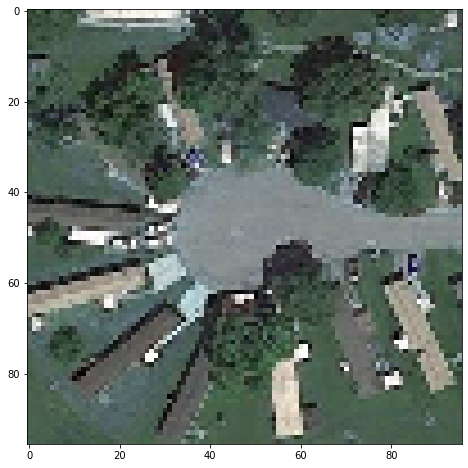

In [13]:
    mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)

In [14]:
if First_Train: model, MAML_loss_tracker, MAML_val_topks, MAML_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=MAML_learning_rate, 
                                                                learning_rate1=MAML_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs=np.load(dir+mtype+'_val_accs.npy')
    epoch_tracker=np.load(dir+'epoch_tracker.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.094
Validation Accuracy:  21.6282901763916
Validation Top3 Accuracy:  42.1875
Epoch 20 - loss: 0.090
Validation Accuracy:  29.9342098236084
Validation Top3 Accuracy:  53.53618240356445
Epoch 30 - loss: 0.086
Validation Accuracy:  38.24013137817383
Validation Top3 Accuracy:  61.842105865478516
Epoch 40 - loss: 0.083
Validation Accuracy:  39.88486862182617
Validation Top3 Accuracy:  65.21381378173828
Epoch 50 - loss: 0.081
Validation Accuracy:  47.03947448730469
Validation Top3 Accuracy:  70.06578826904297
Epoch 60 - loss: 0.078
Validation Accuracy:  49.095394134521484
Validation Top3 Accuracy:  73.68421173095703
Epoch 70 - loss: 0.077
Validation Accuracy:  49.25986862182617
Validation Top3 Accuracy:  72.94407653808594
Epoch 80 - loss: 0.075
Validation Accuracy:  55.016448974609375
Validation Top3 Accuracy:  77.5493392944336
Epoch 90 - loss: 0.073
Validation Accuracy:  56.99013137817383
Validation Top3 Accuracy:  79.35855102539062
Epoch 100 - loss: 0.073
Validation Acc

In [15]:
acc,topk=make_test(model=model, testloader=test_loader)

Test Accuracy:  63.334922790527344
Test Top3 Accuracy:  83.92572784423828


# MAML* first order approximation with support for n task batch and inner l2 regularization to compensate for approximation

Require: $p(\mathcal{T}):$ distribution over tasks 

Require: $\alpha, \beta:$ step size hyperparameters

1: randomly initialize $\theta$

2: while not done $\mathbf{d o}$

3: $\quad$ Sample batch of tasks $\mathcal{T}_{i} \sim p(\mathcal{T})$

4: $\quad$ for all $\mathcal{T}_{i}$ do 

5: $\quad$ $\quad$ Evaluate $\nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right)$ with respect to $K$ examples 

6: $\quad$ $\quad$ Compute adapted parameters with gradient descent: $\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right) + ||\theta||_2$

7: $\quad$ end for

8: $\quad$Update $\theta \leftarrow \theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}})\right)$

9: end while




tensor(40, dtype=torch.int32) storage_tank


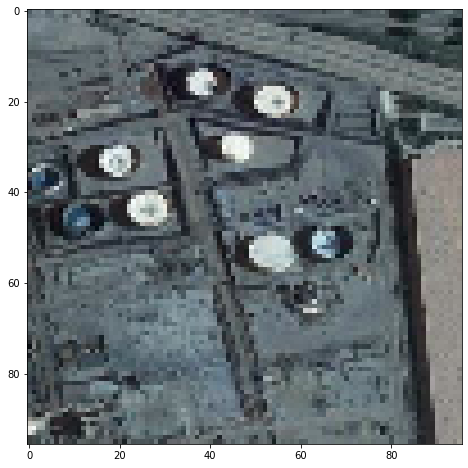

In [16]:
mtype='MAML'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

make_example(train_loader=train_loader, classes=classes)
mtype='MAML2'

In [17]:
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs=n_epochs, 
                                                                learning_rate=0.00045, 
                                                                learning_rate1=0.0001/8, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')

MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.061
Validation Accuracy:  26.644737243652344
Validation Top3 Accuracy:  51.72697448730469
Epoch 20 - loss: 0.059
Validation Accuracy:  34.046051025390625
Validation Top3 Accuracy:  60.36184310913086
Epoch 30 - loss: 0.054
Validation Accuracy:  41.94078826904297
Validation Top3 Accuracy:  67.1875
Epoch 40 - loss: 0.056
Validation Accuracy:  43.58552551269531
Validation Top3 Accuracy:  73.02631378173828
Epoch 50 - loss: 0.051
Validation Accuracy:  48.4375
Validation Top3 Accuracy:  73.68421173095703
Epoch 60 - loss: 0.049
Validation Accuracy:  55.50986862182617
Validation Top3 Accuracy:  77.63157653808594
Epoch 70 - loss: 0.047
Validation Accuracy:  57.894737243652344
Validation Top3 Accuracy:  80.18092346191406
Epoch 80 - loss: 0.048
Validation Accuracy:  58.3059196472168
Validation Top3 Accuracy:  81.90789794921875
Epoch 90 - loss: 0.048
Validation Accuracy:  57.97697448730469
Validation Top3 Accuracy:  81.8256607055664
Epoch 100 - loss: 0.047
Validation Accuracy:  6

In [18]:
acc,topk=make_test(model=model, testloader=test_loader)


Test Accuracy:  68.55915832519531
Test Top3 Accuracy:  87.59542083740234


## MAML 32 way 1 shot 

In [19]:
Params= Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': 0.00005, 'MetaLR': 0.006, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': n_epochs, 'aug': True,
                   'num_classes': 45}
if No_Overlap:
    Params['num_classes']=26
model = get_meta_model(Params)
train_loader, val_loader, test_loader, c_dim, classes, ytrain = get_data(dir=dir, mtype=mtype,nwaykshot=True)
model.to(device)
mtype = 'MAMLnk'

if First_Train: modelnk, epoch_tracker, MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks, MAML_nk_trainacc = trainMAML(mtype,
                                                                                              model,
                                                                                              train_loader, 
                                                                                              Params, 
                                                                                              val_loader,print_stride1 = print_stride,
                                                                                              nwaykshot=True,
                                                                                              trainset=train_loader,
                                                                                              train_labels=ytrain,
                                                                                              )
else: 
    model = get_model(mtype)
    MAML_nk_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_nk_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_nk_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Module `ConvolutionalNeuralNetwork` has no parameter corresponding to the submodule named `classifier` in the dictionary `params` provided as an argument to `forward()`. Using the default parameters for this submodule. The list of the parameters in `params`: [features.0.weight, features.0.bias, features.2.weight, features.3.weight, features.3.bias, features.5.weight, features.6.weight, features.6.bias, features.8.weight, features.9.weight, features.9.bias, features.11.weight, features.12.weight, features.12.bias, features.14.weight, features.15.weight, features.15.bias, fce.weight, fce.bias].


On Epoch  10
Train Loss 0.007816105507887326
Validation Accuracy:  24.919872283935547
Validation Top3 Accuracy:  47.19551467895508
On Epoch  20
Train Loss 0.008816789262569867
Validation Accuracy:  26.762821197509766
Validation Top3 Accuracy:  50.160255432128906
On Epoch  30
Train Loss 0.008228893176867412
Validation Accuracy:  37.5
Validation Top3 Accuracy:  60.41666793823242
On Epoch  40
Train Loss 0.008110045527036373
Validation Accuracy:  39.503204345703125
Validation Top3 Accuracy:  61.778846740722656
On Epoch  50
Train Loss 0.006450776655513506
Validation Accuracy:  42.14743423461914
Validation Top3 Accuracy:  66.18589782714844
On Epoch  60
Train Loss 0.007470267514387767
Validation Accuracy:  42.54807662963867
Validation Top3 Accuracy:  66.10576629638672
On Epoch  70
Train Loss 0.007510226315412766
Validation Accuracy:  45.99359130859375
Validation Top3 Accuracy:  68.9102554321289
On Epoch  80
Train Loss 0.006407182305478132
Validation Accuracy:  46.47435760498047
Validation Top

In [20]:
acc,topk=make_test(model=modelnk, testloader=test_loader)

Test Accuracy:  52.473793029785156
Test Top3 Accuracy:  75.0913314819336


## RESISC CNN with Augs

---

In [21]:
mtype='CNN_Aug'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_Aug_loss_tracker, CNN_Aug_val_topks, CNN_Aug_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_Aug_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_Aug_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_Aug_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.087
Validation Accuracy:  33.73397445678711
Validation Top3 Accuracy:  57.0512809753418
Epoch 20 - loss: 0.080
Validation Accuracy:  42.86859130859375
Validation Top3 Accuracy:  66.58654022216797
Epoch 30 - loss: 0.076
Validation Accuracy:  48.07692337036133
Validation Top3 Accuracy:  71.15384674072266
Epoch 40 - loss: 0.072
Validation Accuracy:  55.528846740722656
Validation Top3 Accuracy:  77.48397064208984
Epoch 50 - loss: 0.068
Validation Accuracy:  56.971153259277344
Validation Top3 Accuracy:  79.32691955566406
Epoch 60 - loss: 0.062
Validation Accuracy:  61.61859130859375
Validation Top3 Accuracy:  83.33333587646484
Epoch 70 - loss: 0.067
Validation Accuracy:  64.82371520996094
Validation Top3 Accuracy:  83.57371520996094
Epoch 80 - loss: 0.064
Validation Accuracy:  65.06410217285156
Validation Top3 Accuracy:  84.77564239501953
Epoch 90 - loss: 0.065
Validation Accuracy:  64.98397064208984
Validation Top3 Accuracy:  84.93589782714844
Epoch 100 - loss: 0.061
Val

In [22]:
acc,topk = make_test(model=model, testloader=test_loader,get_worse=True)

Test Accuracy:  71.49380493164062
Test Top3 Accuracy:  88.50460815429688
16 = Best Task ID 
113 = Worst Task ID 


## RESISC CNN no Augs

---

In [23]:
mtype='CNN'
train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)

if First_Train: model, CNN_loss_tracker, CNN_val_topks, CNN_val_accs, epoch_tracker = train(n_epochs=n_epochs, 
                                                                learning_rate=CNN_learning_rate, 
                                                                learning_rate1=CNN_learning_rate, 
                                                                train_loader=train_loader, 
                                                                val_loader=val_loader, 
                                                                c_dim=c_dim, 
                                                                mtype=mtype,
                                                                augs=False,print_stride1=print_stride)
else: 
    model = get_model(mtype)
    CNN_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    CNN_val_topks=np.load(dir+mtype+'_val_topks.npy')
    CNN_val_accs=np.load(dir+mtype+'_val_accs.npy')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 10 - loss: 0.001
Validation Accuracy:  32.77243423461914
Validation Top3 Accuracy:  52.72435760498047
Epoch 20 - loss: 0.003
Validation Accuracy:  26.121795654296875
Validation Top3 Accuracy:  46.63461685180664
Epoch 30 - loss: 0.004
Validation Accuracy:  26.602563858032227
Validation Top3 Accuracy:  44.471153259277344
Epoch 40 - loss: 0.003
Validation Accuracy:  24.118589401245117
Validation Top3 Accuracy:  42.628204345703125
Epoch 50 - loss: 0.000
Validation Accuracy:  27.32371711730957
Validation Top3 Accuracy:  44.71154022216797
Epoch 60 - loss: 0.000
Validation Accuracy:  28.76602554321289
Validation Top3 Accuracy:  46.55448532104492
Epoch 70 - loss: 0.000
Validation Accuracy:  28.846153259277344
Validation Top3 Accuracy:  46.394229888916016
Epoch 80 - loss: 0.078
Validation Accuracy:  19.711538314819336
Validation Top3 Accuracy:  35.89743423461914
Epoch 90 - loss: 0.027
Validation Accuracy:  24.679487228393555
Validation Top3 Accuracy:  41.987178802490234
Epoch 100 - loss: 

In [24]:
acc,topk = make_test(model=model, testloader=test_loader,get_worse=True)

Test Accuracy:  23.415660858154297
Test Top3 Accuracy:  41.51048278808594
10 = Best Task ID 
39 = Worst Task ID 


## RESISC CHARTS

---

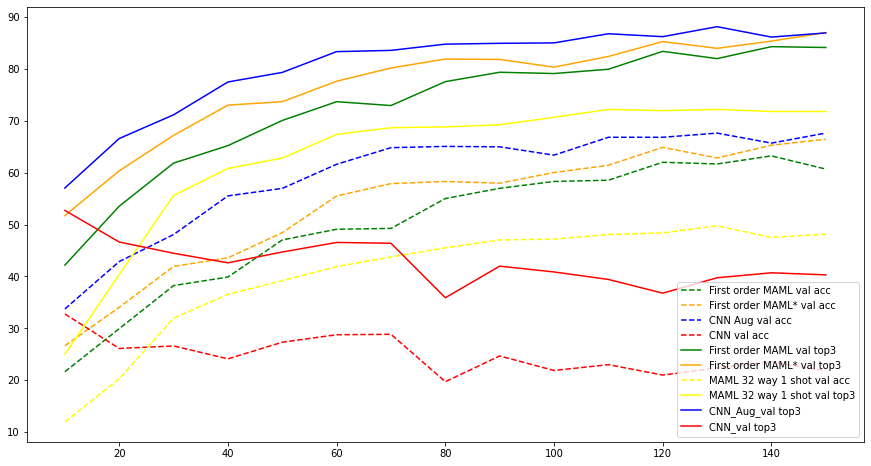

In [25]:
make_train_plot(MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs, MAML_val_topks, CNN_Aug_val_topks, CNN_val_topks, epoch_tracker,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2,MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks
)

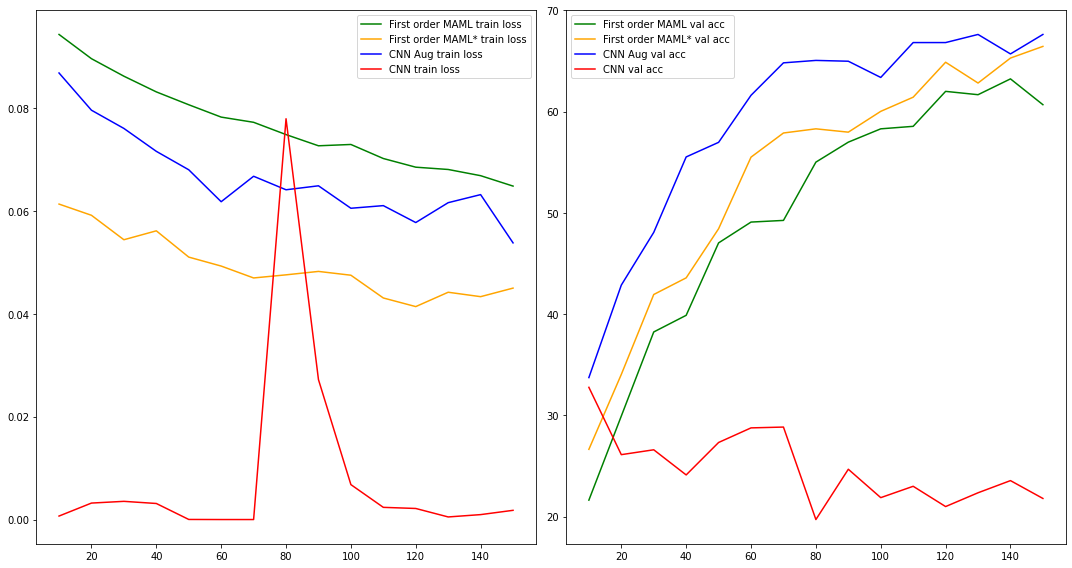

In [26]:
make_two_plots(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker, MAML_val_accs, CNN_Aug_val_accs, CNN_val_accs,MAML_loss_tracker2,MAML_val_accs2,MAML_val_topks2)

## UC MERCED

---

In [27]:
UC_MAML_learning_rate = 0.0006
UC_CNN_learning_rate = 0.0006
UC_epochs = 3
UC_batch_size = 32

UC_data = np.load(dir+'UCMerced_images96.npy')
UC_labels = np.load(dir+'UCMerced_classes.npy')
UC_classes = np.load(dir+'UCMerced_class_names.npy')

UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

UCtrainset = make_dataset(UC_train_data, UC_train_labels)
UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

UCtestset = make_dataset(UC_test_data, UC_test_labels)
UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)

def UC_get_data():
    UC_data = np.load(dir+'UCMerced_images96.npy')
    UC_labels = np.load(dir+'UCMerced_classes.npy')
    UC_classes = np.load(dir+'UCMerced_class_names.npy')

    UC_train_data, UC_test_data, UC_train_labels, UC_test_labels = train_test_split(UC_data, UC_labels, test_size = 0.8, stratify = UC_labels)

    UCtrainset = make_dataset(UC_train_data, UC_train_labels)
    UCtrain_loader = DataLoader(UCtrainset, batch_size=int(batch_size), shuffle=True)

    UCtestset = make_dataset(UC_test_data, UC_test_labels)
    UCtest_loader = torch.utils.data.DataLoader(UCtestset, batch_size, drop_last = True, shuffle=True)
    return UCtrain_loader, UCtest_loader

In [28]:
def UC_train(model1, trainloader, epochs=3, lr=0.0006):
    loss_tracker, epoch_tracker,acc_tracker = [], [], []
    #model.load('UC')
    model = copy.deepcopy(model1).to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr = lr)
    for epoch in range(1, epochs+1):
        losses = 0
        accs = []
        acc = 0

        for X, y in trainloader:
            y_ = y 
            y = one_hot_embedding(y.to(device), len(UC_classes)).float()
            X = X.float().to(device)
            for param in model.parameters(): param.grad = None
            yhat = model(X)
            pred_loss = bce_loss(yhat, y)
            pred_loss.backward()
            optimizer.step()
            losses += pred_loss.item()
           
        for x, y in trainloader:
            x, y = x.to(device).float(), y.to(device).float()
            yhat = model(x)
            
            yhat_max = torch.max(yhat, dim = 1)[1]
            correct = torch.sum(yhat_max == y)
            size = x.shape[0]            
            accs.append(100*(correct/size).data.item())
        print('UC Epoch ',epoch,"Train Accuracy: ",torch.mean(torch.FloatTensor(accs)).data.item())
        acc_tracker.append(torch.mean(torch.FloatTensor(accs)).data.item())
        epoch_tracker.append(epoch)
        loss_tracker.append(losses)
    return model, epoch_tracker, loss_tracker,acc_tracker
def avg_UC_test(mtype,runs,model=None):
    model1 = get_model(mtype=mtype,load=True)
    if mtype=='MAMLnk':
        model1 = model
    test_acc,test_topk = [], [] 
    for _ in range(runs):
        model2= copy.deepcopy(model1.to('cpu')).to(device)
        UC_MAML_learning_rate = 0.0006
        UC_CNN_learning_rate = 0.0006
        UC_epochs = 3
        UC_batch_size = 32
        UCtrain_loader,UCtest_loader = UC_get_data()
        model2.fce = nn.Linear(1024, 21)
        model2 = model.to(device)
        model2, epoch_tracker, CNN_Aug_loss_tracker,CNN_AUG_acc_tracker = UC_train(model1=model2, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc,topk =make_test(model=model2, testloader=UCtest_loader,get_worse=False)
        test_acc.append(acc)
        test_topk.append(topk)
    print(mtype + 'Accuracy on UC as an avg of ',runs,": ",np.mean(test_acc))
    print(mtype + 'TopK on UC as an avg of ',runs,": ",np.mean(test_topk))

In [29]:
mtype='MAML'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker, MAML_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.65178680419922
UC Epoch  2 Train Accuracy:  79.46428680419922
UC Epoch  3 Train Accuracy:  92.1875


In [30]:
acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAML',20)


Test Accuracy:  71.81490325927734
Test Top3 Accuracy:  91.28605651855469
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.875
UC Epoch  2 Train Accuracy:  87.5
UC Epoch  3 Train Accuracy:  88.61607360839844
Test Accuracy:  71.69470977783203
Test Top3 Accuracy:  92.1875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.96428680419922
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  87.72321319580078
Test Accuracy:  71.45433044433594
Test Top3 Accuracy:  90.08413696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.96428680419922
UC Epoch  2 Train Accuracy:  83.25892639160156
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  74.45913696289062
Test Top3 Accuracy:  92.24759674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.52678680419922
UC Epoch  2 Train Accuracy:  83.48213958740234
UC Epoch  3 Train Accuracy:  91.51786041259766
Test Accuracy:  71.39423370361328
Test Top3 Accuracy:  92.72836303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.63392639160156
UC Epoch  2 Train Accuracy:  81.02678680419922
UC Epoch  3 Train Accuracy:  91.51786041259766
Test Accuracy:  70.85336303710938
Test Top3 Accuracy:  92.06730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.20536041259766
UC Epoch  2 Train Accuracy:  81.02678680419922
UC Epoch  3 Train Accuracy:  85.71428680419922
Test Accuracy:  73.31730651855469
Test Top3 Accuracy:  92.90865325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.41963958740234
UC Epoch  2 Train Accuracy:  79.24107360839844
UC Epoch  3 Train Accuracy:  89.73213958740234
Test Accuracy:  73.31730651855469
Test Top3 Accuracy:  93.08894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  82.58928680419922
UC Epoch  3 Train Accuracy:  88.16963958740234
Test Accuracy:  71.99519348144531
Test Top3 Accuracy:  92.96875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.625
UC Epoch  2 Train Accuracy:  83.92857360839844
UC Epoch  3 Train Accuracy:  93.75
Test Accuracy:  70.43269348144531
Test Top3 Accuracy:  91.04566955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.625
UC Epoch  2 Train Accuracy:  78.125
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  70.55288696289062
Test Top3 Accuracy:  91.46634674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  66.51786041259766
UC Epoch  2 Train Accuracy:  79.6875
UC Epoch  3 Train Accuracy:  87.94642639160156
Test Accuracy:  70.73316955566406
Test Top3 Accuracy:  89.72355651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.41071319580078
UC Epoch  2 Train Accuracy:  81.25
UC Epoch  3 Train Accuracy:  91.96428680419922
Test Accuracy:  72.53605651855469
Test Top3 Accuracy:  90.98558044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.41963958740234
UC Epoch  2 Train Accuracy:  83.25892639160156
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  72.41586303710938
Test Top3 Accuracy:  90.92548370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  80.35713958740234
UC Epoch  3 Train Accuracy:  89.73213958740234
Test Accuracy:  72.59615325927734
Test Top3 Accuracy:  92.06730651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.53571319580078
UC Epoch  2 Train Accuracy:  83.70536041259766
UC Epoch  3 Train Accuracy:  90.40178680419922
Test Accuracy:  71.03365325927734
Test Top3 Accuracy:  92.36779022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  91.74107360839844
Test Accuracy:  73.13701629638672
Test Top3 Accuracy:  91.34615325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  65.40178680419922
UC Epoch  2 Train Accuracy:  82.58928680419922
UC Epoch  3 Train Accuracy:  93.30357360839844
Test Accuracy:  71.21394348144531
Test Top3 Accuracy:  91.04566955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.30357360839844
UC Epoch  2 Train Accuracy:  80.13392639160156
UC Epoch  3 Train Accuracy:  91.96428680419922
Test Accuracy:  70.49279022216797
Test Top3 Accuracy:  91.76683044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.4375
UC Epoch  2 Train Accuracy:  87.05357360839844
UC Epoch  3 Train Accuracy:  94.19642639160156
Test Accuracy:  74.75961303710938
Test Top3 Accuracy:  92.78845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.64286041259766
UC Epoch  2 Train Accuracy:  79.91071319580078
UC Epoch  3 Train Accuracy:  90.40178680419922
Test Accuracy:  70.49279022216797
Test Top3 Accuracy:  91.04566955566406
MAMLAccuracy on UC as an avg of  20 :  71.9441104888916
MAMLTopK on UC as an avg of  20 :  91.74278831481934


In [31]:
mtype='MAML2'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, MAML_loss_tracker2,MAML2_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.66963958740234
UC Epoch  2 Train Accuracy:  86.60713958740234
UC Epoch  3 Train Accuracy:  93.30357360839844


In [32]:
acc,topk =make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAML2',20)

Test Accuracy:  75.0
Test Top3 Accuracy:  93.02884674072266
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.75892639160156
UC Epoch  2 Train Accuracy:  85.26786041259766
UC Epoch  3 Train Accuracy:  92.63392639160156
Test Accuracy:  76.02163696289062
Test Top3 Accuracy:  93.56970977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.33928680419922
UC Epoch  2 Train Accuracy:  92.41071319580078
UC Epoch  3 Train Accuracy:  97.54463958740234
Test Accuracy:  76.86298370361328
Test Top3 Accuracy:  95.61298370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.90178680419922
UC Epoch  2 Train Accuracy:  89.28571319580078
UC Epoch  3 Train Accuracy:  95.98213958740234
Test Accuracy:  75.12019348144531
Test Top3 Accuracy:  94.35095977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.5625
UC Epoch  2 Train Accuracy:  88.16963958740234
UC Epoch  3 Train Accuracy:  94.41963958740234
Test Accuracy:  75.60095977783203
Test Top3 Accuracy:  92.84855651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.47321319580078
UC Epoch  2 Train Accuracy:  87.5
UC Epoch  3 Train Accuracy:  96.65178680419922
Test Accuracy:  77.10336303710938
Test Top3 Accuracy:  92.66826629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.45536041259766
UC Epoch  2 Train Accuracy:  88.83928680419922
UC Epoch  3 Train Accuracy:  95.08928680419922
Test Accuracy:  77.76441955566406
Test Top3 Accuracy:  93.02884674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.89286041259766
UC Epoch  2 Train Accuracy:  82.58928680419922
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  74.87980651855469
Test Top3 Accuracy:  92.42788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.63392639160156
UC Epoch  2 Train Accuracy:  89.73213958740234
UC Epoch  3 Train Accuracy:  94.86607360839844
Test Accuracy:  76.50240325927734
Test Top3 Accuracy:  94.29086303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  87.27678680419922
UC Epoch  3 Train Accuracy:  96.875
Test Accuracy:  74.39904022216797
Test Top3 Accuracy:  92.24759674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.21428680419922
UC Epoch  2 Train Accuracy:  85.04463958740234
UC Epoch  3 Train Accuracy:  95.08928680419922
Test Accuracy:  78.00480651855469
Test Top3 Accuracy:  94.23076629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.53571319580078
UC Epoch  2 Train Accuracy:  86.83036041259766
UC Epoch  3 Train Accuracy:  97.32142639160156
Test Accuracy:  75.90144348144531
Test Top3 Accuracy:  93.50961303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.00892639160156
UC Epoch  2 Train Accuracy:  87.94642639160156
UC Epoch  3 Train Accuracy:  96.875
Test Accuracy:  78.06490325927734
Test Top3 Accuracy:  94.77163696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.4375
UC Epoch  2 Train Accuracy:  85.49107360839844
UC Epoch  3 Train Accuracy:  95.3125
Test Accuracy:  75.84134674072266
Test Top3 Accuracy:  94.83173370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.0
UC Epoch  2 Train Accuracy:  90.84821319580078
UC Epoch  3 Train Accuracy:  94.86607360839844
Test Accuracy:  76.5625
Test Top3 Accuracy:  93.50961303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.77678680419922
UC Epoch  2 Train Accuracy:  87.72321319580078
UC Epoch  3 Train Accuracy:  94.19642639160156
Test Accuracy:  76.44230651855469
Test Top3 Accuracy:  93.08894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.66071319580078
UC Epoch  2 Train Accuracy:  87.05357360839844
UC Epoch  3 Train Accuracy:  94.41963958740234
Test Accuracy:  76.68269348144531
Test Top3 Accuracy:  92.54808044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.67857360839844
UC Epoch  2 Train Accuracy:  88.16963958740234
UC Epoch  3 Train Accuracy:  94.19642639160156
Test Accuracy:  76.62259674072266
Test Top3 Accuracy:  94.29086303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.78571319580078
UC Epoch  2 Train Accuracy:  87.5
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  75.90144348144531
Test Top3 Accuracy:  92.48798370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.0
UC Epoch  2 Train Accuracy:  90.625
UC Epoch  3 Train Accuracy:  96.20536041259766
Test Accuracy:  74.87980651855469
Test Top3 Accuracy:  93.02884674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.21428680419922
UC Epoch  2 Train Accuracy:  86.60713958740234
UC Epoch  3 Train Accuracy:  94.86607360839844
Test Accuracy:  75.72115325927734
Test Top3 Accuracy:  93.99038696289062
MAML2Accuracy on UC as an avg of  20 :  76.24399032592774
MAML2TopK on UC as an avg of  20 :  93.56670684814453


In [33]:
mtype='MAMLnk'
model = modelnk

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)

modelnk, epoch_tracker, MAMLnk_loss_tracker, MAMLnk_acc_tracker = UC_train(model1=modelnk, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_MAML_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.67857360839844
UC Epoch  2 Train Accuracy:  92.1875
UC Epoch  3 Train Accuracy:  98.88392639160156


In [34]:
acc,topk =make_test(model=modelnk, testloader=UCtest_loader,get_worse=False)
avg_UC_test('MAMLnk',20,model=modelnk)

Test Accuracy:  32.331729888916016
Test Top3 Accuracy:  57.99279022216797
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  82.36607360839844
UC Epoch  2 Train Accuracy:  92.41071319580078
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  25.360576629638672
Test Top3 Accuracy:  48.79807662963867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  83.03571319580078
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  98.88392639160156
Test Accuracy:  27.764423370361328
Test Top3 Accuracy:  50.18029022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  85.9375
UC Epoch  2 Train Accuracy:  97.32142639160156
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  28.966346740722656
Test Top3 Accuracy:  44.77163314819336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.89286041259766
UC Epoch  2 Train Accuracy:  97.99107360839844
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  21.694711685180664
Test Top3 Accuracy:  42.127403259277344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  86.16071319580078
UC Epoch  2 Train Accuracy:  98.21428680419922
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  28.064903259277344
Test Top3 Accuracy:  50.36057662963867


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.76786041259766
UC Epoch  2 Train Accuracy:  95.75892639160156
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  25.240385055541992
Test Top3 Accuracy:  46.21394348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.66071319580078
UC Epoch  2 Train Accuracy:  96.42857360839844
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  24.939903259277344
Test Top3 Accuracy:  46.875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  82.14286041259766
UC Epoch  2 Train Accuracy:  97.99107360839844
UC Epoch  3 Train Accuracy:  98.88392639160156
Test Accuracy:  29.747596740722656
Test Top3 Accuracy:  52.10336685180664


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.88392639160156
UC Epoch  2 Train Accuracy:  97.76786041259766
UC Epoch  3 Train Accuracy:  98.4375
Test Accuracy:  25.540864944458008
Test Top3 Accuracy:  44.591346740722656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.34821319580078
UC Epoch  2 Train Accuracy:  97.32142639160156
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  27.46394157409668
Test Top3 Accuracy:  48.377403259277344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.69642639160156
UC Epoch  2 Train Accuracy:  97.32142639160156
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  27.584135055541992
Test Top3 Accuracy:  48.737979888916016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.24107360839844
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  26.622596740722656
Test Top3 Accuracy:  45.252403259277344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.85713958740234
UC Epoch  2 Train Accuracy:  95.3125
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  29.6875
Test Top3 Accuracy:  51.80288314819336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  97.99107360839844
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  28.24519157409668
Test Top3 Accuracy:  49.63942337036133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  83.48213958740234
UC Epoch  2 Train Accuracy:  96.65178680419922
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  19.53125
Test Top3 Accuracy:  38.581729888916016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.91071319580078
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  97.99107360839844
Test Accuracy:  26.201923370361328
Test Top3 Accuracy:  46.33413314819336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.24107360839844
UC Epoch  2 Train Accuracy:  97.99107360839844
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  27.283653259277344
Test Top3 Accuracy:  49.278846740722656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  87.05357360839844
UC Epoch  2 Train Accuracy:  98.21428680419922
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  25.540864944458008
Test Top3 Accuracy:  47.11538314819336


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  82.58928680419922
UC Epoch  2 Train Accuracy:  96.65178680419922
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  28.545673370361328
Test Top3 Accuracy:  46.814903259277344


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.02678680419922
UC Epoch  2 Train Accuracy:  95.75892639160156
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  27.34375
Test Top3 Accuracy:  48.31730651855469
MAMLnkAccuracy on UC as an avg of  20 :  26.568509578704834
MAMLnkTopK on UC as an avg of  20 :  47.31370162963867


In [35]:
mtype='CNN'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_loss_tracker,CNN_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.77678680419922
UC Epoch  2 Train Accuracy:  92.85713958740234
UC Epoch  3 Train Accuracy:  97.32142639160156


In [36]:
acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
avg_UC_test('CNN',20)

Test Accuracy:  46.63461685180664
Test Top3 Accuracy:  71.45433044433594
loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.34821319580078
UC Epoch  2 Train Accuracy:  93.97321319580078
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  45.73317337036133
Test Top3 Accuracy:  70.61298370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.65178680419922
UC Epoch  2 Train Accuracy:  97.32142639160156
UC Epoch  3 Train Accuracy:  97.54463958740234
Test Accuracy:  43.75
Test Top3 Accuracy:  67.78845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.11607360839844
UC Epoch  2 Train Accuracy:  94.64286041259766
UC Epoch  3 Train Accuracy:  97.76786041259766
Test Accuracy:  44.17067337036133
Test Top3 Accuracy:  70.73316955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.01786041259766
UC Epoch  2 Train Accuracy:  96.65178680419922
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  44.35095977783203
Test Top3 Accuracy:  69.89183044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.65178680419922
UC Epoch  2 Train Accuracy:  95.75892639160156
UC Epoch  3 Train Accuracy:  94.41963958740234
Test Accuracy:  42.127403259277344
Test Top3 Accuracy:  68.62980651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  93.97321319580078
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  44.77163314819336
Test Top3 Accuracy:  71.33413696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.78571319580078
UC Epoch  2 Train Accuracy:  96.42857360839844
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  44.050479888916016
Test Top3 Accuracy:  69.83173370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.08036041259766
UC Epoch  2 Train Accuracy:  94.19642639160156
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  42.60817337036133
Test Top3 Accuracy:  68.93029022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  79.01786041259766
UC Epoch  2 Train Accuracy:  96.20536041259766
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  44.831729888916016
Test Top3 Accuracy:  68.62980651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.875
UC Epoch  2 Train Accuracy:  97.09821319580078
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  44.29086685180664
Test Top3 Accuracy:  68.75


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.53571319580078
UC Epoch  2 Train Accuracy:  98.21428680419922
UC Epoch  3 Train Accuracy:  97.76786041259766
Test Accuracy:  46.45432662963867
Test Top3 Accuracy:  70.25240325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.09821319580078
UC Epoch  2 Train Accuracy:  94.64286041259766
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  43.38942337036133
Test Top3 Accuracy:  68.08894348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  81.47321319580078
UC Epoch  2 Train Accuracy:  96.875
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  43.14904022216797
Test Top3 Accuracy:  69.23076629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.21428680419922
UC Epoch  2 Train Accuracy:  90.625
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  44.591346740722656
Test Top3 Accuracy:  70.37259674072266


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.19642639160156
UC Epoch  2 Train Accuracy:  95.3125
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  44.35095977783203
Test Top3 Accuracy:  70.07211303710938


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  78.79463958740234
UC Epoch  2 Train Accuracy:  95.75892639160156
UC Epoch  3 Train Accuracy:  99.55357360839844
Test Accuracy:  42.06730651855469
Test Top3 Accuracy:  67.96875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.33928680419922
UC Epoch  2 Train Accuracy:  97.54463958740234
UC Epoch  3 Train Accuracy:  100.0
Test Accuracy:  44.65144348144531
Test Top3 Accuracy:  68.68990325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.00892639160156
UC Epoch  2 Train Accuracy:  95.08928680419922
UC Epoch  3 Train Accuracy:  99.77678680419922
Test Accuracy:  44.230770111083984
Test Top3 Accuracy:  69.53125


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.30357360839844
UC Epoch  2 Train Accuracy:  96.20536041259766
UC Epoch  3 Train Accuracy:  99.10713958740234
Test Accuracy:  42.127403259277344
Test Top3 Accuracy:  67.30769348144531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.19642639160156
UC Epoch  2 Train Accuracy:  93.97321319580078
UC Epoch  3 Train Accuracy:  99.33036041259766
Test Accuracy:  42.84855651855469
Test Top3 Accuracy:  65.80529022216797
CNNAccuracy on UC as an avg of  20 :  43.927283477783206
CNNTopK on UC as an avg of  20 :  69.12259635925292


In [37]:
mtype='CNN_Aug'
model = get_model(mtype=mtype,load=True)

if Freeze:
    for param in model.parameters():
        param.requires_grad = False

model.fce = nn.Linear(1024, 21)
model = model.to(device)
#model.save('UC'+mtype)

model, epoch_tracker, CNN_Aug_loss_tracker,CNN_AUG_acc_tracker = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.20536041259766
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  86.60713958740234


In [38]:
acc,topk=make_test(model=model, testloader=UCtest_loader,get_worse=False)

Test Accuracy:  75.0
Test Top3 Accuracy:  93.44951629638672


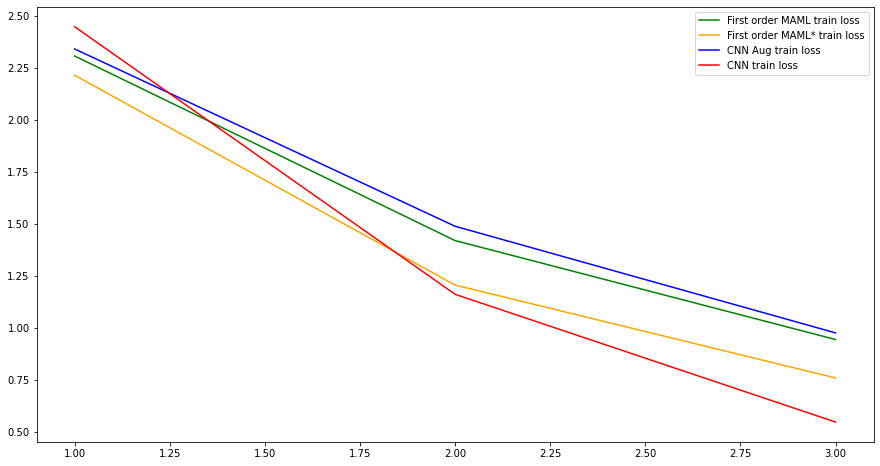

loading...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.66963958740234
UC Epoch  2 Train Accuracy:  82.36607360839844
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  74.21875
Test Top3 Accuracy:  92.66826629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.88392639160156
UC Epoch  2 Train Accuracy:  83.92857360839844
UC Epoch  3 Train Accuracy:  87.27678680419922
Test Accuracy:  75.12019348144531
Test Top3 Accuracy:  92.42788696289062


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  67.41071319580078
UC Epoch  2 Train Accuracy:  87.05357360839844
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  77.52404022216797
Test Top3 Accuracy:  94.05048370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  73.21428680419922
UC Epoch  2 Train Accuracy:  85.04463958740234
UC Epoch  3 Train Accuracy:  88.39286041259766
Test Accuracy:  74.69951629638672
Test Top3 Accuracy:  93.56970977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.78571319580078
UC Epoch  2 Train Accuracy:  85.71428680419922
UC Epoch  3 Train Accuracy:  91.07142639160156
Test Accuracy:  76.50240325927734
Test Top3 Accuracy:  94.05048370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.23213958740234
UC Epoch  2 Train Accuracy:  88.16963958740234
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  76.92308044433594
Test Top3 Accuracy:  93.93029022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.19642639160156
UC Epoch  2 Train Accuracy:  88.39286041259766
UC Epoch  3 Train Accuracy:  95.3125
Test Accuracy:  77.10336303710938
Test Top3 Accuracy:  93.68990325927734


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.33036041259766
UC Epoch  2 Train Accuracy:  85.04463958740234
UC Epoch  3 Train Accuracy:  89.73213958740234
Test Accuracy:  74.39904022216797
Test Top3 Accuracy:  94.17066955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.52678680419922
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  75.48076629638672
Test Top3 Accuracy:  94.83173370361328


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  75.89286041259766
UC Epoch  2 Train Accuracy:  85.04463958740234
UC Epoch  3 Train Accuracy:  91.51786041259766
Test Accuracy:  77.10336303710938
Test Top3 Accuracy:  94.41105651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  71.42857360839844
UC Epoch  2 Train Accuracy:  82.14286041259766
UC Epoch  3 Train Accuracy:  93.97321319580078
Test Accuracy:  78.30529022216797
Test Top3 Accuracy:  94.95191955566406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.41963958740234
UC Epoch  2 Train Accuracy:  85.71428680419922
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  74.81970977783203
Test Top3 Accuracy:  92.78845977783203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  64.28571319580078
UC Epoch  2 Train Accuracy:  83.70536041259766
UC Epoch  3 Train Accuracy:  90.625
Test Accuracy:  74.75961303710938
Test Top3 Accuracy:  93.44951629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  74.55357360839844
UC Epoch  2 Train Accuracy:  84.375
UC Epoch  3 Train Accuracy:  93.30357360839844
Test Accuracy:  76.62259674072266
Test Top3 Accuracy:  93.32933044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.76786041259766
UC Epoch  2 Train Accuracy:  83.92857360839844
UC Epoch  3 Train Accuracy:  91.29463958740234
Test Accuracy:  74.21875
Test Top3 Accuracy:  91.76683044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  70.3125
UC Epoch  2 Train Accuracy:  86.83036041259766
UC Epoch  3 Train Accuracy:  92.41071319580078
Test Accuracy:  75.30048370361328
Test Top3 Accuracy:  92.54808044433594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  77.45536041259766
UC Epoch  2 Train Accuracy:  80.58036041259766
UC Epoch  3 Train Accuracy:  90.17857360839844
Test Accuracy:  73.31730651855469
Test Top3 Accuracy:  91.58654022216797


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  72.76786041259766
UC Epoch  2 Train Accuracy:  85.9375
UC Epoch  3 Train Accuracy:  94.19642639160156
Test Accuracy:  76.62259674072266
Test Top3 Accuracy:  93.62980651855469


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  68.75
UC Epoch  2 Train Accuracy:  84.59821319580078
UC Epoch  3 Train Accuracy:  91.29463958740234
Test Accuracy:  74.81970977783203
Test Top3 Accuracy:  94.23076629638672


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  69.19642639160156
UC Epoch  2 Train Accuracy:  84.82142639160156
UC Epoch  3 Train Accuracy:  92.1875
Test Accuracy:  73.97836303710938
Test Top3 Accuracy:  90.68509674072266
CNN_AugAccuracy on UC as an avg of  20 :  75.59194679260254
CNN_AugTopK on UC as an avg of  20 :  93.3383415222168


In [39]:
basic_train_plot(epoch_tracker, MAML_loss_tracker, CNN_Aug_loss_tracker, CNN_loss_tracker,MAML_loss_tracker2)
avg_UC_test('CNN_Aug',20)

## Thoughts on UC


It is incrediably easy to overfit to UC mercer if we train each optimization scheme from sctrach as shown below. Since We know afte training on RESIC and then trasnfer learning on UC, we can say the model training on RESIC learned important features of the schenes that would otherwise not have been learned if it was just UC. Now when comparing optimization schemes, we can examine the testing accuracy of UC after training on RESIC and say which model's weights were primed for fast learning and fast adaption.


In [40]:
def fresh_train_UC(mtype,load):
    model = get_model(mtype=mtype,load=load)
    UC_MAML_learning_rate = 0.0006
    UC_CNN_learning_rate = 0.0006
    UC_epochs = 3
    UC_batch_size = 32
    UCtrain_loader,UCtest_loader = UC_get_data()
    model.fce = nn.Linear(1024, 21)
    model = model.to(device)
    #model.save('UC'+mtype)
    if mtype == 'CNN':
        print(mtype)
        model, epoch_tracker, CNN_Aug_loss_tracker,acc = UC_train(model1=model, trainloader=UCtrain_loader, epochs=UC_epochs, lr=UC_CNN_learning_rate)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
    elif mtype == "MAML":
        print(mtype)
        model, _, _, _, _=  train(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype, augs=True)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

    elif mtype == 'MAML2':
        print(mtype)
        model, _, _, _, _, =  train2(UC_epochs, UC_CNN_learning_rate, UC_CNN_learning_rate, UCtrain_loader, UCtest_loader, c_dim, mtype)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)
        return acc
    elif mtype == 'MAMLnk':
        print(mtype)
        Params= Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': UC_MAML_learning_rate, 'MetaLR': UC_MAML_learning_rate, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': UC_epochs, 'aug': True,
                   'num_classes': 45}
        model,_,_,_,_,_ =trainMAML(mtype,model,UCtrain_loader,Params,val_loader,print_stride,nwaykshot=False)
        acc,topk = make_test(model=model, testloader=UCtest_loader,get_worse=False)

CNN_acc = fresh_train_UC('CNN',load=False)
MAML_acc = fresh_train_UC('MAML',load=False)
MAML2_acc = fresh_train_UC('MAML2',load=False)
# MAMLnk_acc = fresh_train_UC('MAMLnk',load=False) dont run this get "CUDA error: device-side assert triggered" error, I think above calls demonstrate it enough how easy it is to overfit to the data with the best 3 models


    

CNN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


UC Epoch  1 Train Accuracy:  76.33928680419922
UC Epoch  2 Train Accuracy:  93.08036041259766
UC Epoch  3 Train Accuracy:  98.21428680419922
Test Accuracy:  32.091346740722656
Test Top3 Accuracy:  54.44711685180664
MAML


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saving...
Test Accuracy:  5.408653736114502
Test Top3 Accuracy:  15.985576629638672
MAML2
MAML2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


saving...
Test Accuracy:  6.850961685180664
Test Top3 Accuracy:  14.302885055541992


# MAML second order on traditonal dataloader, tuned to best performance by hand 

In [ ]:
mtype='MAML'

Params = {'nways': 32, 'kshots': 1, 'in_channels': 3, 'hidden_size': 2, 
                  'innerStep': .00005/16, 'MetaLR': .006/64, 'number_of_tasks': 32,
                  'Order': False, 'outerVSinner': 1, 'epoch': n_epochs, 'aug': True,
                   'num_classes': 45}
model = get_meta_model(Params,load=False)

train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
mtype='MAMLnk'
model.to(device)
if First_Train: modelnk, epoch_tracker, MAML_nk_loss_tracker, MAML_nk_val_accs, MAML_nk_val_topks, MAML_nk_train_acc = trainMAML(mtype,
                                                                                              model,
                                                                                              train_loader,
                                                                                              Params,
                                                                                              val_loader, 
                                                                                               print_stride1=print_stride
                                                                                              )
else: 
    model = get_model(mtype)
    MAML_nk_loss_tracker=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_nk_val_topks=np.load(dir+mtype+'_val_topks.npy')
    MAML_nk_val_accs=np.load(dir+mtype+'_val_accs.npy')
acc,topk=make_test(model=modelnk, testloader=test_loader)
avg_UC_test('MAMLnk',20,model=modelnk)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Module `ConvolutionalNeuralNetwork` has no parameter corresponding to the submodule named `classifier` in the dictionary `params` provided as an argument to `forward()`. Using the default parameters for this submodule. The list of the parameters in `params`: [features.0.weight, features.0.bias, features.2.weight, features.3.weight, features.3.bias, features.5.weight, features.6.weight, features.6.bias, features.8.weight, features.9.weight, features.9.bias, features.11.weight, features.12.weight, features.12.bias, features.14.weight, features.15.weight, features.15.bias, fce.weight, fce.bias].


On Epoch  10
Train Loss 0.001486522432357546
Validation Accuracy:  11.924342155456543
Validation Top3 Accuracy:  20.0657901763916
On Epoch  20
Train Loss 0.0015040748649173313
Validation Accuracy:  13.980262756347656
Validation Top3 Accuracy:  24.177631378173828
On Epoch  30
Train Loss 0.0014806627754181151
Validation Accuracy:  15.131579399108887
Validation Top3 Accuracy:  26.973684310913086


first order maml with 16 task inner loop l2 reg on n way k shot data, best learning rates normalized by batch size 

In [ ]:
mtype='MAML2'
Params['nways']=5
Params['number_of_tasks']=32
train_loader, val_loader, test_loader, c_dim, classes, ytrain = get_data(dir=dir, mtype=mtype,nwaykshot=True)
if First_Train: model, MAML_loss_tracker2, MAML_val_topks2, MAML_val_accs2, epoch_tracker, = train2(n_epochs, 
                                                                                                    .00045*Params['nways']/batch_size, 
                                                                                                    .0001/8*Params['nways']/batch_size,
                                                                                                    train_loader, 
                                                                                                    val_loader, 
                                                                                                    c_dim, mtype,
                                                                                                    print_stride1 = print_stride,
                                                                                                    trainset= train_loader, 
                                                                                                    nwaykshot=True , 
                                                                                                    train_labels = ytrain,
                                                                                                    Params=Params)
else: 
    model = get_model(mtype)
    MAML_loss_tracker2=np.load(dir+mtype+'_loss_tracker.npy')
    MAML_val_topks2=np.load(dir+mtype+'_val_topks.npy')
    MAML_val_accs2=np.load(dir+mtype+'_val_accs.npy')
avg_UC_test(mtype,20)

## Scrap Work Area 

---

In [ ]:
#GRAD DIAGNOSTICS
'''
print("PARAMS YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA == pB).all())
print("GRAD YOU ARE CHECKING")
for pA, pB in zip(CNN.parameters(), CNN1.parameters()):
  print((pA.grad == pB.grad))
'''

In [ ]:
# def trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2):
#     train_loader, val_loader, test_loader, c_dim, classes = get_data(dir=dir, mtype=mtype)
#     make_example(train_loader=train_loader, classes=classes)
#     if mtype=='CNN' or mtype == "MAML":
#         model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train(n_epochs=n_epochs, 
#                                                                     learning_rate=learning_rate_1, 
#                                                                     learning_rate1=learning_rate_2, 
#                                                                     train_loader=train_loader, 
#                                                                     val_loader=val_loader, 
#                                                                     c_dim=c_dim, 
#                                                                     mtype=mtype,print_stride1=1)
#     elif mtype == 'MAML2'
#          model, loss_tracker, val_topk_tracker, val_acc_tracker, epoch_tracker = train2(n_epochs=n_epochs, 
#                                                                     learning_rate=learning_rate_1, 
#                                                                     learning_rate1=learning_rate_2, 
#                                                                     train_loader=train_loader, 
#                                                                     val_loader=val_loader, 
#                                                                     c_dim=c_dim, 
#                                                                     mtype=mtype,print_stride1=1)
#     return model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker

# def AVG_n_model(dir,mtype,n_epochs,learning_rate_1,learning_rate_2,runs=5,UC_or_RES):
#     list_loss_tracker,list_val_topk_tracker,list_val_acc_tracker,testacc,testtopk = [],[],[],[],[]
#     for _ in range(runs):
#         if UC_or_RES=='RES'
#             model,test_loader,loss_tracker,val_topk_tracker,val_acc_tracker,epoch_tracker = trainmodel(dir,mtype,n_epochs,learning_rate_1,learning_rate_2)
#             list_loss_tracker.append(loss_tracker)
#             list_val_topk_tracker.append(val_topk_tracker)
#             list_val_acc_tracker.append(val_acc_tracker)

#             test_acc, test_topk  = make_test(model,test_loader)
#             testacc.append(test_acc)
#             testtopk.append(test_topk)
#         else:
#             testacc1 , testtopk1 = fresh_train_UC(mtype,load=True)
#             testacc.append(testacc1)
#             testtopk.append(testtopk1)


#     avg_loss = numpy.mean(numpy.array(list_loss_tracker), axis=0)
#     avg_valtopk = numpy.mean(numpy.array(list_val_topk_tracker), axis=0)
#     avg_valacc = numpy.mean(numpy.array(val_acc_tracker), axis=0)
    
#     test__valacc = numpy.mean(numpy.array(testacc), axis=0)
#     test___valacc = numpy.mean(numpy.array(testtopk), axis=0)

#     return avg_loss,avg_valtopk,avg_valacc,test__valacc,test___valacc





    
